In [2]:
# add ..\ to path
import sys
sys.path.append('..\\')
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation


In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
import numpy as np
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.compiler import transpile
from typing import Union, Optional
def iterative_phase_estimation_v2(U: Union[UnitaryGate, np.array], 
                               num_evals: int, 
                               eigenstate: Optional[Union[QuantumCircuit, np.array]],
                               backend,
                               num_qubits=1) -> float:
    
    # Data type management:
    # Convert U to a gate if it's a numpy array
    if isinstance(U, np.ndarray):
        U = UnitaryGate(U)
    
    elif isinstance(U, SparsePauliOp):
        op = Operator(U)
        U = UnitaryGate(op)
    
    elif isinstance(U, Operator):
        U = UnitaryGate(U)


    # Prepare the initial eigenstate
    if isinstance(eigenstate, np.ndarray):
        eigenstate_circuit = QuantumCircuit(num_qubits, name='eigenstate')
        # the eigenstate is a vector of complex numbers that determine the state of the qubits other than the control qubit
        eigenstate_circuit.initialize(eigenstate)

    else:
        eigenstate_circuit = eigenstate

    # Actually create the circuit
    qc = QuantumCircuit(num_qubits + 1,1)
    qc.append(eigenstate_circuit, range(1, num_qubits + 1)) # Apply the eigenstate to the qubits
    qc.h(0) # Apply Hadamard to the control qubit
    u = U.control(1) # Create the controlled-U gate
    qc.append(u, range(num_qubits + 1)) # Apply the controlled-U gate
    qc.h(0) # Apply Hadamard to the control qubit
    qc.measure(0, cbit=0) # Measure the control qubit

    # Execute the circuit num_evals times
    job = backend.run(transpile(qc, backend), dynamic=False, shots=num_evals, memory=True, meas_level=0, meas_return='single')
    num_zeros = 0
    result = job.result()
    counts = result.get_counts()
    print(counts)
    if '0' in counts:
        num_zeros = counts['0']
    tot = sum(counts.values())
    return num_zeros / tot, qc


In [4]:
# New plan: Come up with a Hamiltonian that is easier to simulate.
# Try idk XX or something.
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.circuit.library import UnitaryGate
import random
from qiskit_algorithms import NumPyEigensolver
import numpy as np
from qiskit_aer import Aer

# rand_angle = random.randint(0, 100) % np.pi
test_hamiltonian = np.array([[1, 0], [0, np.exp(1j*np.pi/4)]])
test_hamiltonian = UnitaryGate(test_hamiltonian)
exact_eigensolver = NumPyEigensolver()
exact_eigenvalue = exact_eigensolver.compute_eigenvalues(test_hamiltonian)
selected_backend = Aer.get_backend('qasm_simulator')

eigenstate = np.array([0, 1]) # initial state
iterations = []
estimations = []

for i in range(1, 100, 5):
    num_evals = i
    print(f'current number of evaluations: {num_evals}')
    p_0, qc = iterative_phase_estimation_v2(test_hamiltonian, num_evals, eigenstate, selected_backend, num_qubits=1)
    print(p_0)
    estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0))
    iterations.append(i)
    estimations.append(estimated_eigenvalue)
    print(f"estimation: {estimated_eigenvalue} \n exact answer: {exact_eigenvalue}")


current number of evaluations: 1
{'1': 1}
0.0
estimation: 3.141592653589793 
 exact answer: {   'aux_operators_evaluated': None,
    'eigenstates': [Statevector([0.+0.j, 1.+0.j],
            dims=(2,))],
    'eigenvalues': array([0.70710678])}
current number of evaluations: 6
{'0': 6}
1.0
estimation: 0.0 
 exact answer: {   'aux_operators_evaluated': None,
    'eigenstates': [Statevector([0.+0.j, 1.+0.j],
            dims=(2,))],
    'eigenvalues': array([0.70710678])}
current number of evaluations: 11
{'1': 3, '0': 8}
0.7272727272727273
estimation: 1.0989344895152546 
 exact answer: {   'aux_operators_evaluated': None,
    'eigenstates': [Statevector([0.+0.j, 1.+0.j],
            dims=(2,))],
    'eigenvalues': array([0.70710678])}
current number of evaluations: 16
{'0': 14, '1': 2}
0.875
estimation: 0.7227342478134157 
 exact answer: {   'aux_operators_evaluated': None,
    'eigenstates': [Statevector([0.+0.j, 1.+0.j],
            dims=(2,))],
    'eigenvalues': array([0.70710678])}


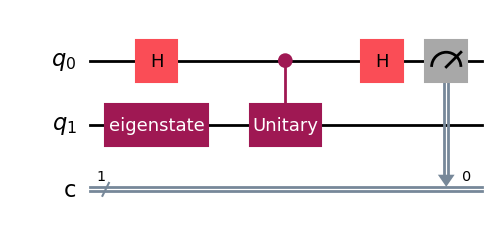

In [5]:
qc.draw('mpl')

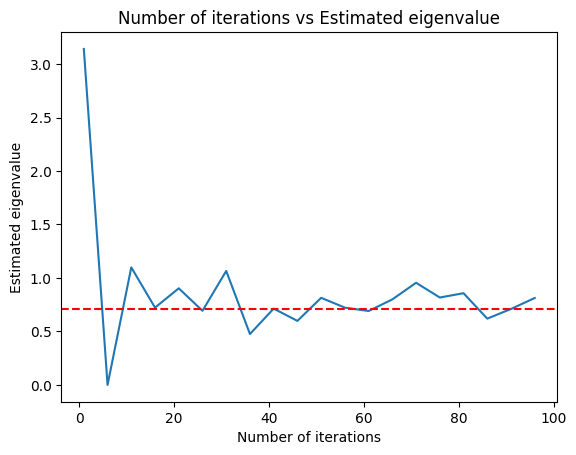

In [6]:
# plot # iterations vs estimation

import matplotlib.pyplot as plt
plt.plot(iterations, estimations)
plt.xlabel('Number of iterations')
plt.ylabel('Estimated eigenvalue')
plt.title('Number of iterations vs Estimated eigenvalue')
# add verical line at exact eigenvalue
exact_result = exact_eigenvalue.eigenvalues[0]
plt.axhline(exact_result, color='r', linestyle='--')
plt.show()



In [ ]:
# TESTNG V2
import scipy
import scipy.linalg
rand_angle = random.randint(0, 100) % np.pi
print(f"random angle: {rand_angle}")
test_hamiltonian = np.array([[3, rand_angle], [rand_angle, 1]])
U = scipy.linalg.expm(1j * test_hamiltonian)

exact_eigensolver = NumPyEigensolver()
exact_eigenvalue, eigenvectors= scipy.linalg.eig(test_hamiltonian)
print(f"rotation matrix: {test_hamiltonian}")
print(f"exact eigenvalue: {exact_eigenvalue}")

# pick eigenstate that corresponds to smallest eigenvalue
eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)]
iterations = []
estimations = []

for i in range(1, 1000, 10):
    num_evals = i
    print(f'current number of evaluations: {num_evals}')
    p_0, qc = iterative_phase_estimation_v2(U, num_evals, eigenstate, selected_backend, num_qubits=1)
    print(p_0)
    estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0))
    iterations.append(i)
    estimations.append(estimated_eigenvalue)
    print(f"estimation: {estimated_eigenvalue} \n exact answer: {min(exact_eigenvalue)}")


In [ ]:
# plot # iterations vs estimation
plt.plot(iterations, estimations)
plt.xlabel('Number of iterations')
plt.ylabel('Estimated eigenvalue')
plt.title('Number of iterations vs Estimated eigenvalue')
# add verical line at exact eigenvalue
exact_result = exact_eigenvalue[1]
plt.axhline(exact_result, color='r', linestyle='--')
plt.show()